# MOK 5-ha Bartending Agent
# Google Colab Notebook

# Setup and Installation

In [37]:
# Install required packages
!pip install google-generativeai>=0.3.0 tenacity>=8.2.3 gradio>=4.0.0 cartesia>=2.0.0 python-dotenv>=1.0.0 langchain-google-genai langchain-core

In [38]:
# Import common libraries
import os
import logging
import sys
import re
from typing import Dict, List, Optional, Tuple
import gradio as gr
from google.colab import files
from google.colab import userdata
import matplotlib.pyplot as plt
import io
from PIL import Image
import base64
import requests
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage, add_messages
from langchain_core.tools import tool
import json # For parsing tool arguments if needed
import re # For parsing the menu

In [39]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Upload Bartender Avatar (Optional)

Using default avatar image


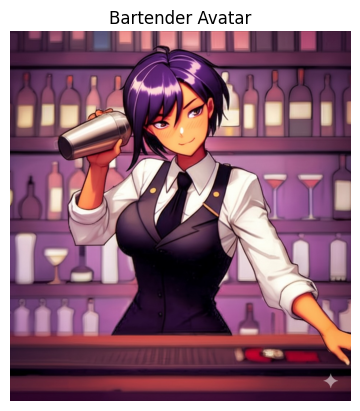

Avatar saved to bartender_avatar.jpg


In [40]:
use_default_avatar = True

# Default avatar URL
default_avatar_url = "https://github.com/gen-ai-capstone-project-bartender-agent/MOK-5-ha/blob/main/assets/bartender_avatar_ai_studio.jpeg?raw=true"

if use_default_avatar:
    # Download default avatar
    try:
        response = requests.get(default_avatar_url)
        if response.status_code == 200:
            avatar_bytes = response.content
            avatar_image = Image.open(io.BytesIO(avatar_bytes))
            print("Using default avatar image")
        else:
            print(f"Failed to download default avatar. Status code: {response.status_code}")
            # Create a blank avatar as fallback
            avatar_image = Image.new('RGB', (300, 300), color = (73, 109, 137))
    except Exception as e:
        print(f"Error using default avatar: {e}")
        # Create a blank avatar as fallback
        avatar_image = Image.new('RGB', (300, 300), color = (73, 109, 137))
else:
    # Ask user to upload an avatar
    print("Please upload an avatar image:")
    uploaded = files.upload()
    if uploaded:
        avatar_key = next(iter(uploaded))
        avatar_bytes = uploaded[avatar_key]
        avatar_image = Image.open(io.BytesIO(avatar_bytes))
        print(f"Uploaded avatar: {avatar_key}")
    else:
        print("No avatar uploaded, using default")
        # Create a blank avatar as fallback
        avatar_image = Image.new('RGB', (300, 300), color = (73, 109, 137))

# Display the avatar
plt.imshow(avatar_image)
plt.axis('off')
plt.title("Bartender Avatar")
plt.show()

# Save avatar for use in Gradio
avatar_path = "bartender_avatar.jpg"
avatar_image.save(avatar_path)
print(f"Avatar saved to {avatar_path}")

# Bartending Agent Implementation

In [41]:
try:
    # Using 'ggenai' alias consistent with user's snippets
    import google.generativeai as ggenai
    from google.api_core import retry as core_retry # For potential core retries
    from google.generativeai import types as genai_types # For specific types if needed later
except ImportError:
    print("Error: google.generativeai library not found.")
    print("Please install it using: pip install google-generativeai")
    sys.exit(1)

# Tenacity for retries on specific functions
try:
    from tenacity import (
        retry as tenacity_retry, # Alias to avoid confusion with google.api_core.retry
        stop_after_attempt,
        wait_exponential,
        retry_if_exception_type,
        before_sleep_log
    )
except ImportError:
    print("Warning: tenacity library not found. Retries on API calls will not be enabled.")
    print("Install it using: pip install tenacity")
    # Define a dummy decorator if tenacity is missing
    def tenacity_retry(*args, **kwargs):
        def decorator(func):
            return func
        return decorator
    RETRYABLE_EXCEPTIONS = (Exception,) # Fallback to generic exception
    before_sleep_log = lambda logger, level: None # Dummy function

try:
    from cartesia import Cartesia
    from cartesia.tts import OutputFormat_Raw, TtsRequestIdSpecifier
except ImportError:
    print("Error: Cartesia library not found.")
    print("Please ensure it's installed with: pip install cartesia")
    sys.exit(1)

In [45]:
# --- Configuration ---

# Get API Key (Ensure this is set in your .env file or system environment)
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
CARTESIA_API_KEY = userdata.get("CARTESIA_API_KEY") # Load Cartesia key

if not GOOGLE_API_KEY:
    logger.error("FATAL: GEMINI_API_KEY not found in environment variables or .env file.")
    raise EnvironmentError("GEMINI_API_KEY is required but not found.")

if not CARTESIA_API_KEY:
    logger.error("FATAL: CARTESIA_API_KEY not found in environment variables or .env file.")
    # Decide if TTS is optional or required. Assuming required for now.
    raise EnvironmentError("CARTESIA_API_KEY is required but not found.")

In [46]:
# Initialize Cartesia Client (ONCE at module load)
try:
    # Replace "your-chosen-voice-id" with an actual valid ID from Cartesia
    CARTESIA_VOICE_ID = "6f84f4b8-58a2-430c-8c79-688dad597532" # Example placeholder ID - CHANGE THIS
    if not CARTESIA_VOICE_ID or "your-chosen-voice-id" in CARTESIA_VOICE_ID:
         logger.warning("CARTESIA_VOICE_ID is not set to a valid ID. Please edit bartending_agent.py.")
         # Decide if this is fatal. Maybe proceed without voice for now?

    cartesia_client = Cartesia(
        api_key=userdata.get("CARTESIA_API_KEY"),
        )
    logger.info("Successfully initialized Cartesia client.")
    # Optional: Could add a check here to verify the voice ID exists using the client if possible
except Exception as e:
     logger.exception("Fatal: Failed to initialize Cartesia client.")
     raise RuntimeError("Cartesia client initialization failed.") from e

In [47]:
@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but you could connect this to a live stock
    # database, or you could use Gemini's multi-modal capabilities and take live photos of
    # your cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    MENU:
    Cocktails with Liquor:
    Daiquiri - $10.00
    Martini - $13.00
    Long Island - $12.00
    Old Fashioned - $12.00
    Negroni - $11.00
    Cosmopolitan - $12.00
    Manhattan - $12.00

    Beer:
    Tap Beer - $5.00
    Classic Brew - $5.00
    IPA - $6.00

    Non-Alcoholic Beverages:
    Water - $1.00
    Iced Tea - $2.00
    Lemonade - $2.00
    Soda - $3.00

    Modifiers:
    Liquor Options: Vodka, Tequila, Gin, Whiskey, Rum, Brandy; Default option: Vodka
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'shaken', 'stirred', 'neat', 'dry', etc.

    “neat” means no ice, straight from the bottle.
    “on the rocks” means served with ice.
    “dry” is used for martinis to specify less vermouth.
    “dirty” means adding olive juice to a martini.
    “perfect” is a 50/50 mix of dry and sweet vermouth, often for a Manhattan.
    “Chaser” means a separate drink to follow, typically non-alcoholic.
  """

# --- Tenacity retry decorator for _call_gemini_api ---
# ... (keep the @tenacity_retry decorator as it was) ...
@tenacity_retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=2, max=10),
    #retry=retry_if_exception_type(RETRYABLE_EXCEPTIONS),
    before_sleep=before_sleep_log(logger, logging.WARNING) if callable(before_sleep_log) else None, # Check if callable
    reraise=True # Re-raise the exception if all retries fail
)
def _call_gemini_api(prompt_content: List[Dict], config: Dict) -> ggenai.types.GenerateContentResponse: # Adjusted input type hint
    """Internal function to call the Gemini API with retry logic (Stateless)."""
    logger.debug("Calling Gemini API...")
    # Uses the globally initialized 'model'
    response = model.generate_content(
        contents=prompt_content, # Correct parameter name is 'contents'
        generation_config=config,
        # safety_settings can be added here if needed
    )
    logger.debug("Gemini API call successful.")
    return response


# --- New LangGraph-style System Prompt ---
# ... (keep BARTENDERBOT_SYSINT definition as it was) ...
BARTENDERBOT_SYSINT = (
    "You are a Bartender-Bot, an interactive drink ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items and their prices (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user for their business and "
    "politely say their order will be ready shortly!"
    "\n\n"
    "The bar's name is MOK 5-ha, pronounced as 'Moksha'. If a customer asks about the name, explain that:\n"
    "Moksha represents liberation from the cycle of rebirth (samsara) and union with the divine. It is achieved through spiritual enlightenment, freeing the soul from karma and earthly attachments to attain eternal bliss."
)

In [48]:
# --- Tool Definitions ---

# (Keep your existing @tool def get_menu() -> str: ... here)

# Helper function to parse the menu string (you might need to adjust regex based on exact format)
def _parse_menu_items(menu_str: str) -> Dict[str, float]:
    items = {}
    # Regex to find lines like "Item Name - $Price.xx"
    # Handles potential variations in spacing
    pattern = re.compile(r"^\s*(.+?)\s*-\s*\$(\d+\.\d{2})\s*$", re.MULTILINE)
    matches = pattern.findall(menu_str)
    for match in matches:
        item_name = match[0].strip()
        price = float(match[1])
        items[item_name.lower()] = price # Store lowercase for easier matching
    return items

@tool
def add_to_order(item_name: str, quantity: int = 1) -> str:
    """
    Adds the specified quantity of an item to the customer's order.
    Use this AFTER verifying the item is on the menu.
    Args:
        item_name: The exact name of the item from the menu.
        quantity: The number of this item to add (defaults to 1).
    """
    global current_process_order_state # Use global to access state within this call

    menu_str = get_menu() # Get the current menu
    menu_items = _parse_menu_items(menu_str)
    item_lower = item_name.lower()

    if item_lower in menu_items:
        price = menu_items[item_lower]
        for _ in range(quantity):
            current_process_order_state['order'].append({"name": item_name, "price": price}) # Modify the state directly
        logger.info(f"Tool: Added {quantity} x '{item_name}' to order.")
        return f"Successfully added {quantity} x {item_name} to the order."
    else:
        logger.warning(f"Tool: Attempted to add item '{item_name}' not found in parsed menu.")
        # Try a fuzzy match maybe? For now, return error.
        # Consider listing similar items if needed.
        return f"Error: Item '{item_name}' could not be found on the current menu. Please verify the item name."

@tool
def clear_order() -> str:
    """Removes all items from the current order."""
    global current_process_order_state
    current_process_order_state['order'] = [] # Clear the state
    logger.info("Tool: Cleared order.")
    return "The order has been cleared."

@tool
def get_order() -> str:
    """Returns the current list of items in the order for the agent to see."""
    global current_process_order_state
    order_list = current_process_order_state['order']
    if not order_list:
        return "The order is currently empty."
    order_details = "\n".join([f"- {item['name']} (${item['price']:.2f})" for item in order_list])
    total = sum(item['price'] for item in order_list)
    return f"Current Order:\n{order_details}\nTotal: ${total:.2f}"

@tool
def confirm_order() -> str:
    """
    Displays the current order to the user and asks for confirmation.
    The user's response will be processed in the next turn.
    """
    global current_process_order_state
    order_list = current_process_order_state['order']
    if not order_list:
        return "There is nothing in the order to confirm. Please add items first."

    order_details = "\n".join([f"- {item['name']} (${item['price']:.2f})" for item in order_list])
    total = sum(item['price'] for item in order_list)
    confirmation_request = f"Here is your current order:\n{order_details}\nTotal: ${total:.2f}\n\nIs this correct? You can ask to add/remove items or proceed to place the order."
    logger.info("Tool: Generated order confirmation request for user.")
    # This tool doesn't actually *place* the order, it just prepares the text for the LLM to relay
    return confirmation_request # The LLM should incorporate this text into its response to the user

@tool
def place_order() -> str:
    """Finalizes and places the customer's confirmed order."""
    global current_process_order_state
    order_list = current_process_order_state['order']
    if not order_list:
        return "Cannot place an empty order. Please add items first."

    # In a real system, this would interact with a POS or backend API.
    # Here, we'll just log it and modify the state.
    order_details = ", ".join([item['name'] for item in order_list])
    total = sum(item['price'] for item in order_list)
    logger.info(f"Tool: Placing order: [{order_details}], Total: ${total:.2f}")

    # Mark order as finished (though 'finished' isn't explicitly in Gradio state)
    # We can clear the order after placing it for this simple setup
    current_process_order_state['order'] = [] # Clear order after placing
    current_process_order_state['finished'] = True # Set a flag if needed later

    return f"Order placed successfully! Your items ({order_details}) totalling ${total:.2f} will be ready shortly."

# List of all tools for the LLM
tools = [get_menu, add_to_order, clear_order, get_order, confirm_order, place_order]

In [49]:
# Model initialization

# With the LangChain setup:
try:
    # Ensure GOOGLE_API_KEY is set (e.g., from Colab Secrets or input)
    if not GOOGLE_API_KEY:
        raise ValueError("GOOGLE_API_KEY not found.")

    # Use ChatGoogleGenerativeAI and bind the tools
    # Note: Use a model that supports tool calling well, like gemini-pro or newer flash/pro models
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash", # Or "gemini-pro", etc. Check model compatibility
        temperature=0.7,
        max_output_tokens=2048,
        google_api_key=GOOGLE_API_KEY
    ).bind_tools(tools) # Bind the list of tool functions

    logger.info(f"Successfully initialized LangChain ChatGoogleGenerativeAI model bound with tools.")

except Exception as e:
    logger.exception(f"Fatal: Failed to initialize LangChain Gemini model: {str(e)}")
    raise RuntimeError(
        f"Failed to initialize LangChain Gemini model. Check API key and model name."
    ) from e

In [64]:
# --- New LangGraph-style System Prompt ---
# (Note: The actual tools mentioned here like add_to_order are not yet implemented
# in this specific file structure. The LLM will receive these instructions, but
# the surrounding code doesn't execute LangGraph tools.)
BARTENDERBOT_SYSINT = (
    "You are a Bartender-Bot, an interactive drink ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items and their prices (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user for their business and "
    "politely say their order will be ready shortly!"
    "\n\n"
    "The bar's name is MOK 5-ha, pronounced as 'Moksha'. If a customer asks about the name, explain that:\n"
    "Moksha represents liberation from the cycle of rebirth (samsara) and union with the divine. It is achieved through spiritual enlightenment, freeing the soul from karma and earthly attachments to attain eternal bliss."
)


# Global variable to hold state accessible by tools within a single process_order call
current_process_order_state = {'order': [], 'finished': False}

def process_order(
    user_input_text: str,
    current_session_history: List[Dict[str, str]],
    current_session_order: List[Dict[str, float]]
) -> Tuple[str, List[Dict[str, str]], List[Dict[str, float]]]:
    """
    Processes user input using LangChain LLM with tool calling, updates state.
    """
    global menu, llm, current_process_order_state # Access global LLM and menu dict

    if not user_input_text:
        logger.warning("Received empty user input.")
        return "Please tell me what you'd like to order.", current_session_history, current_session_order

    # --- Initialize state for this specific call ---
    # Copy Gradio state to our temporary global state accessible by tools
    # NOTE: This global approach is simple for this example but not ideal for concurrent requests.
    # A better approach in a real app might involve classes or context managers.
    current_process_order_state['order'] = current_session_order[:] # Copy list
    current_process_order_state['finished'] = False # Reset finished flag for this turn

    # Prepare message history for LangChain model
    messages = []
    # Add System Prompt
    messages.append(SystemMessage(content=BARTENDERBOT_SYSINT))
    # Add Menu (as system/context info - could also be retrieved via tool call if user asks)
    # This explicitly calls the tool using the correct interface, providing a dummy input(the empty dictionary) that satisfies the method signature, even though the get_menu function itself doesn't use it.
    messages.append(SystemMessage(content="\nHere is the menu:\n" + get_menu.invoke({}))) # Use invoke()

    # Convert Gradio history to LangChain message types
    history_limit = 10
    limited_history = current_session_history[-history_limit:]
    for entry in limited_history:
        role = entry.get("role")
        content = entry.get("content", "")
        if role == "user":
            messages.append(HumanMessage(content=content))
        elif role == "assistant":
            messages.append(AIMessage(content=content)) # Assuming simple text responses previously

    # Add the latest user input
    messages.append(HumanMessage(content=user_input_text))

    logger.info(f"Processing user input for session: {user_input_text}")
    # logger.debug(f"Messages sent to LLM: {messages}")

    try:
        # --- LLM Interaction Loop (Handles Tool Calls) ---
        while True:
            # Invoke the LLM with current messages
            ai_response: AIMessage = llm.invoke(messages)
            # logger.debug(f"LLM Response Object: {ai_response}")

            # Append the AI's response (could be text or tool call request)
            messages.append(ai_response)

            if not ai_response.tool_calls:
                # No tool calls requested, this is the final response to the user
                agent_response_text = ai_response.content
                break # Exit the loop

            # --- Tool Call Execution ---
            logger.info(f"LLM requested tool calls: {ai_response.tool_calls}")
            tool_messages = [] # Collect tool results
            for tool_call in ai_response.tool_calls:
                tool_name = tool_call.get("name")
                tool_args = tool_call.get("args", {})
                tool_id = tool_call.get("id") # Important for ToolMessage

                # Find the corresponding tool function
                selected_tool = next((t for t in tools if t.name == tool_name), None)

                if selected_tool:
                    try:
                        # Execute the tool function with its arguments
                        # Arguments are usually dicts, unpack if needed or pass as is
                        tool_output = selected_tool.invoke(tool_args)
                        logger.info(f"Executed tool '{tool_name}' with args {tool_args}. Output: {tool_output}")
                    except Exception as e:
                        logger.error(f"Error executing tool '{tool_name}': {e}")
                        tool_output = f"Error executing tool {tool_name}: {e}"

                    # Append the result as a ToolMessage
                    tool_messages.append(ToolMessage(content=str(tool_output), tool_call_id=tool_id))
                else:
                    logger.error(f"Tool '{tool_name}' requested by LLM not found.")
                    tool_messages.append(ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_id))

            # Add the tool results to the message history
            messages.extend(tool_messages)
            # Continue the loop to send results back to LLM
            logger.info("Sending tool results back to LLM...")

        # --- End of LLM Interaction Loop ---

        # Final response text is now set
        logger.info(f"Final agent response: {agent_response_text}")

        # --- Update Gradio State ---
        # Use the state potentially modified by tools
        updated_order_from_tools = current_process_order_state['order']

        # Update history for Gradio display
        updated_history_for_gradio = current_session_history[:] # Start with original history for the turn
        updated_history_for_gradio.append({'role': 'user', 'content': user_input_text})
        # We might want to include tool interactions in history for debugging, but maybe not for user display
        # For now, just add the final assistant response
        updated_history_for_gradio.append({'role': 'assistant', 'content': agent_response_text})

        return agent_response_text, updated_history_for_gradio, updated_order_from_tools

    except Exception as e:
        logger.exception(f"Critical error in process_order: {str(e)}")
        error_message = "I'm sorry, an unexpected error occurred during processing. Please try again later."
        # Return original state on critical error
        safe_history = current_session_history[:]
        safe_history.append({'role': 'user', 'content': user_input_text})
        safe_history.append({'role': 'assistant', 'content': error_message})
        return error_message, safe_history, current_session_order

# --- get_voice_audio function ---
# ... (keep the get_voice_audio function as it was) ...

In [65]:
# Define retryable exceptions for Cartesia if known, otherwise use generic ones
# Example: CARTESIA_RETRYABLE_EXCEPTIONS = (cartesia.errors.ServerError, cartesia.errors.RateLimitError, ConnectionError)
# Using generic exceptions for now as specific Cartesia ones aren't known here.
CARTESIA_RETRYABLE_EXCEPTIONS = (ConnectionError, TimeoutError) # Add more specific Cartesia errors if documented

@tenacity_retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=1, max=5),
    retry=retry_if_exception_type(CARTESIA_RETRYABLE_EXCEPTIONS),
    before_sleep=before_sleep_log(logger, logging.WARNING) if callable(before_sleep_log) else None,
    reraise=True
)
def get_voice_audio(text_to_speak: str) -> bytes | None:
    """Calls Cartesia API synchronously to synthesize speech and returns WAV bytes."""
    global cartesia_client, CARTESIA_VOICE_ID # Access the global client and voice ID

    if not text_to_speak or not text_to_speak.strip():
        logger.warning("get_voice_audio received empty text.")
        return None
    if not cartesia_client or not CARTESIA_VOICE_ID:
         logger.error("Cartesia client or voice ID not initialized, cannot generate audio.")
         return None

    try:
        # Replace "MOK 5-ha" with "Moksha" for pronunciation in TTS
        text_for_tts = re.sub(r'MOK 5-ha', 'Moksha', text_to_speak, flags=re.IGNORECASE)
        if text_for_tts != text_to_speak:
            logger.info("Applied 'MOK 5-ha' → 'Moksha' pronunciation for TTS.")

        logger.info(f"Requesting TTS from Cartesia (Voice ID: {CARTESIA_VOICE_ID}) for: '{text_for_tts[:50]}...'")

        # --- Check Cartesia Documentation for the exact method call ---
        # This is a plausible synchronous implementation pattern:
        audio_generator = cartesia_client.tts.bytes(
            model_id="sonic-2",
            transcript=text_for_tts,  # Use the modified text with correct pronunciation
            voice={"mode":"id",
                   "id": CARTESIA_VOICE_ID,
            },
            language="en",
            # Specify desired output format and sample rate
            output_format={"container":"wav",
                           "sample_rate": 24000,
                           "encoding": "pcm_f32le",
            },
        )

        # Concatenate chunks from the generator for a blocking result
        audio_data = b"".join(chunk for chunk in audio_generator)
        # --- End of section requiring Cartesia documentation check ---

        if not audio_data:
            logger.warning("Cartesia TTS returned empty audio data.")
            return None

        logger.info(f"Received {len(audio_data)} bytes of WAV audio data from Cartesia.")
        return audio_data

    # Catch specific Cartesia errors if they exist and are imported
    # except cartesia.errors.CartesiaError as e:
    #    logger.exception(f"Cartesia API error during TTS generation: {e}")
    #    return None
    except Exception as e:
        # Catch any other unexpected error during TTS
        logger.exception(f"Unexpected error generating voice audio with Cartesia: {e}")
        return None

# Gradio Interface Implementation

In [66]:
from typing import Any

def handle_gradio_input(
    user_input: str,
    session_history_state: List[Dict[str, str]],
    session_order_state: List[Dict[str, float]]
) -> Tuple[str, List[Dict[str, str]], List[Dict[str, str]], List[Dict[str, float]], Any]:
    """
    Gradio callback: Takes input/state, calls logic & TTS, returns updates.
    """
    logger.info(f"Gradio input: '{user_input}'")
    logger.debug(f"Received session history state (len {len(session_history_state)}): {session_history_state}")
    logger.debug(f"Received session order state (len {len(session_order_state)}): {session_order_state}")

    # Call text processing logic first
    response_text, updated_history, updated_order = process_order(
        user_input,
        session_history_state,
        session_order_state
    )

    # --- Get Voice Audio ---
    audio_data = None # Default to None
    # Check if there is a non-empty response text to synthesize
    if response_text and response_text.strip():
         audio_data = get_voice_audio(response_text) # Call the imported function
         if audio_data is None:
             logger.warning("Failed to get audio data from get_voice_audio.")
             # Optional: Add indication to user? E.g., append "[Audio failed]" to response_text
    else:
        logger.info("No response text generated, skipping TTS.")
    # --- End Get Voice Audio ---

    # Return updates including audio data (which might be None)
    return "", updated_history, updated_history, updated_order, audio_data

In [67]:
def clear_chat_state() -> Tuple[List, List, List, None]:
    """Clears UI/session state including audio."""
    logger.info("Clear button clicked - Resetting session state.")
    # Return empty lists for Chatbot/history/order, and None for the audio component
    return [], [], [], None

# Launch the Gradio Interface

In [68]:
def launch_bartender_interface():
    theme = gr.themes.Citrus()

    with gr.Blocks(theme=theme) as demo:
        gr.Markdown("# MOK 5-ha Bartending Agent")
        gr.Markdown("Welcome to MOK 5-ha! Ask me for a drink or check your order.")

        # --- Define Session State Variables ---
        history_state = gr.State([])
        order_state = gr.State([])

        # --- Restructured Main Row with 2 Columns (Equal Scaling) ---
        with gr.Row():

            # --- Column 1: Avatar Image ---
            # Scale is relative to other columns in the same row
            with gr.Column(scale=1, min_width=200): # Keep scale=1
                gr.Image(
                    value=avatar_path,  # Use the saved avatar path
                    label="Bartender Avatar",
                    show_label=False,
                    interactive=False,
                    height=600, # Adjust as desired
                    elem_classes=["avatar-image"]
                )

            # --- Column 2: Chat Interface ---
            with gr.Column(scale=1): # <-- Changed scale from 3 to 1
                chatbot_display = gr.Chatbot(
                    [],
                    elem_id="chatbot",
                    label="Conversation",
                    bubble_full_width=False,
                    height=450, # Keep or adjust height for rectangular shape
                    type="messages"
                )
                agent_audio_output = gr.Audio(
                    label="Agent Voice",
                    autoplay=True,
                    streaming=False,
                    format="wav",
                    show_label=True,
                    interactive=False
                )
                msg_input = gr.Textbox(
                    label="Your Order / Message",
                    placeholder="What can I get for you? (e.g., 'I'd like a Margarita', 'Show my order')"
                )
                with gr.Row():
                    clear_btn = gr.Button("Clear Conversation")
                    submit_btn = gr.Button("Send", variant="primary")

        # --- Event Handlers (Remain the same) ---
        submit_inputs = [msg_input, history_state, order_state]
        submit_outputs = [msg_input, chatbot_display, history_state, order_state, agent_audio_output]
        msg_input.submit(handle_gradio_input, submit_inputs, submit_outputs)
        submit_btn.click(handle_gradio_input, submit_inputs, submit_outputs)

        clear_outputs = [chatbot_display, history_state, order_state, agent_audio_output]
        clear_btn.click(clear_chat_state, None, clear_outputs)

    # Launch the interface
    demo.launch(debug=True, share=True)  # share=True to make it accessible via a public URL

# Run the Bartending Agent

In [ ]:
# Launch the interface when this cell is executed
launch_bartender_interface()

<ipython-input-68-16a6a3d9f6e0>:29: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot_display = gr.Chatbot(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://191d6af919643d77aa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
